In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os


In [2]:

# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


## <span style="color:red">Preprocessing</span>

In [3]:
null_counts = df.isnull().sum()
print(null_counts)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


### <span style="color:yellow">No columns have null values</span>

In [4]:
for i in df.columns:
    print("number of unique values in", i, ":", df[i].nunique())

number of unique values in gender : 3
number of unique values in age : 102
number of unique values in hypertension : 2
number of unique values in heart_disease : 2
number of unique values in smoking_history : 6
number of unique values in bmi : 4247
number of unique values in HbA1c_level : 18
number of unique values in blood_glucose_level : 18
number of unique values in diabetes : 2


### <span style="color:yellow">One-hot encoding for gender and smoking_history</span>

In [5]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
print(df_encoded.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0        False         False                    False   
1         0        False         False                    False   
2         0         True         False                    False   
3         0        False         False                     True   
4         0         True         False                     True   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                 False             

### <span style="color:yellow">Normalizing the data</span>

In [6]:
boolean_columns = df_encoded.select_dtypes(include=bool).columns
numerical_columns = df_encoded.select_dtypes(include=np.number).columns
print(boolean_columns)
print(numerical_columns)

Index(['gender_Male', 'gender_Other', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes'],
      dtype='object')


In [7]:
numerical_columns = numerical_columns.drop('diabetes')
boolean_columns = boolean_columns.insert(0, 'diabetes')
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)
df_scaled = pd.concat([df_numerical_scaled, df_encoded[boolean_columns]], axis=1)

In [8]:
df_scaled.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.692704,-0.284439,4.936379,-0.321056,1.001706,0.047704,0,False,False,False,False,False,True,False
1,0.538006,-0.284439,-0.202578,-0.000116,1.001706,-1.426210,0,False,False,False,False,False,False,False
2,-0.616691,-0.284439,-0.202578,-0.000116,0.161108,0.489878,0,True,False,False,False,False,True,False
3,-0.261399,-0.284439,-0.202578,-0.583232,-0.492690,0.416183,0,False,False,True,False,False,False,False
4,1.515058,3.515687,4.936379,-1.081970,-0.679490,0.416183,0,True,False,True,False,False,False,False


### <span style="color:yellow">Train test split</span>

In [9]:
x = df_scaled.drop('diabetes', axis=1)
y = df_scaled['diabetes']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

### <span style="color:yellow">Training an MLP model</span>

In [11]:
# Define the path to the saved model file
model_file = 'mlp_model.keras'

# Check if the model file exists
if os.path.exists(model_file):
    print("Model file exists. Loading the model...")
    # Load the saved model
    mlp_model = load_model(model_file)
else:
    print("Model file does not exist. Training a new model...")
    # Define the MLP model
    mlp_model = Sequential([
        Dense(64, activation='relu', input_shape=(x_train.shape[1],)),  # Input layer
        Dense(32, activation='relu'),  # Hidden layer
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    mlp_model.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # Save the trained model
    mlp_model.save(model_file)
    print("Model trained and saved.")

Model file does not exist. Training a new model...
Epoch 1/50


c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0388 - val_loss: 0.0315
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0313 - val_loss: 0.0315
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0304 - val_loss: 0.0286
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0268 - val_loss: 0.0268
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0265 - val_loss: 0.0263
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0258 - val_loss: 0.0257
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0254 - val_loss: 0.0252
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0233 - val_loss: 0.0254
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0240 - val_loss: 0.0247
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0233 - val_loss: 0.0244
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0241 - val_loss: 0.0246
Epoch 12/50
2000/2000 ━━━━━━━━━━━━━━━━━━━

In [12]:
# Assuming x_test and y_test are already defined

# Make predictions on the test data
y_pred = mlp_model.predict(x_test)

# Calculate the Mean Squared Error (MSE) on the test data
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# Convert y_pred to binary predictions
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

# Ensure y_test is a numpy array and reshape if necessary
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
if y_test_array.ndim > 1:
    y_test_array = y_test_array.reshape(-1)

# Ensure y_pred_binary is a 1-dimensional array
if y_pred_binary.ndim > 1:
    y_pred_binary = y_pred_binary.reshape(-1)

# Compare y_pred_binary with y_test
correct_predictions = np.sum(y_pred_binary == y_test_array)
wrong_predictions = np.sum(y_pred_binary != y_test_array)

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Wrong Predictions: {wrong_predictions}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error on Test Set: 0.023606909757335835
Number of Correct Predictions: 19434
Number of Wrong Predictions: 566


In [13]:
age_distribution = df_encoded['age'].value_counts()
print(age_distribution)
print(f"Number of unique ages: {age_distribution.nunique()}")


age
80.00    5621
51.00    1619
47.00    1574
48.00    1568
53.00    1542
         ... 
0.48       83
1.00       83
0.40       66
0.16       59
0.08       36
Name: count, Length: 102, dtype: int64
Number of unique ages: 98


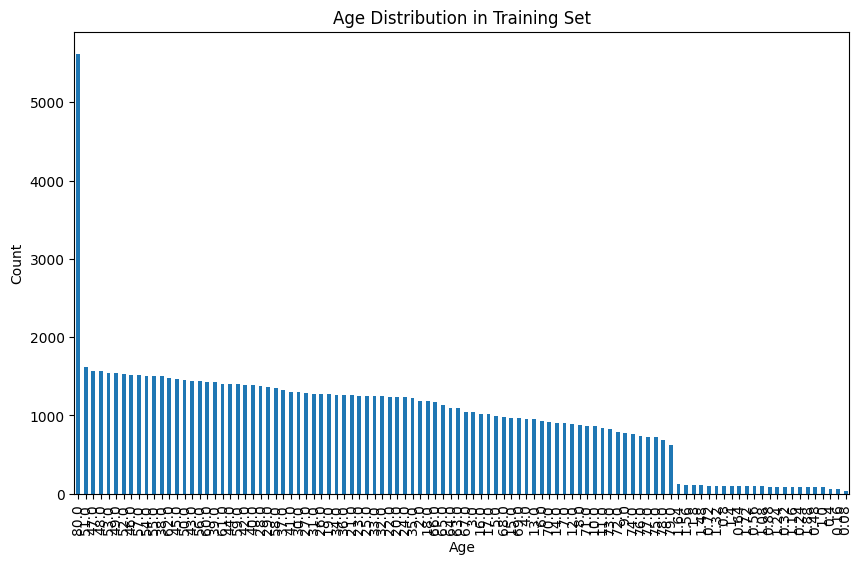

In [14]:
# Plot the age distribution
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()